In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, ReLU, Dropout, LSTM, Bidirectional, Softmax
from tensorflow.keras.regularizers import L2
import tensorflow_addons as tfa

import librosa
import pywt
from skimage.restoration import denoise_wavelet
from loess.loess_1d import loess_1d
import statsmodels.api as sm
import scipy

import matplotlib.pyplot as plt
from IPython.display import Audio

import argparse
from os import listdir
from os.path import join

## Funções

In [3]:

def parse_args():
    '''
    '''
    parser = argparse.ArgumentParser(description='BDLSTM + CNN model trainer')

    parser.add_argument('--df_audio_save_path', help='Path to save the audio signals dataframe')
    parser.add_argument('--df_audio_read_path', help='Path to read the audio signals dataframe')

    return parser.parse_args()


def read_audio_filenames(directory: str) -> list[str]:
    '''

    '''
    return [ filename for filename in listdir(directory) if filename.endswith('.wav') ]


def create_audio_dataframe(filenames: list[str]) -> pd.DataFrame:
    '''
    '''
    parts = [ filename.split('.')[0].split('_') + [filename] for filename in filenames ]

    df = pd.DataFrame(parts, columns=['ID', 'code', 'local1', 'local2', 'device', 'filename'])
    df['ID'] = df['ID'].astype(int)

    return df


def read_audio_content(filepath: str, sample_rate=4000):
    '''
    '''
    data, sr = librosa.load(filepath, sr=sample_rate)
    return data, sr


def segment_audio_content(audio, sample_rate=4000, segment_length=5):
    ''''''
    segments = []
    audio_length = len(audio) / sample_rate

    # print('Audio length', audio_length)

    segment_index = 0
    while segment_index < audio_length:
        t_start = segment_index * sample_rate
        t_end = t_start + segment_length * sample_rate

        segment = audio[ t_start : t_end ]
        segments.append(np.pad(segment, (0, sample_rate * segment_length - len(segment)), 'constant'))
        segment_index += segment_length

    # print(segment_index / segment_length, 'segments read')
    # print([ len(s) for s in segments ])
    return segments


def wdenoise(audio):
    '''Wavelet denoise
    '''
    return denoise_wavelet(audio, wavelet='db5', method='BayesShrink', mode='soft', wavelet_levels=4)
    # return pywt.wavedec(audio, 'db5', mode='zero', level=4)[0]


def apply_loess(audio, frac=1/3, it=5):
    '''
    '''
    # xout, yout, wout = loess_1d(time, audio) # type: ignore
    # return xout, yout
    lowess = sm.nonparametric.lowess
    return lowess(audio, np.arange(0, len(audio), 1), frac=frac, it=it)
    

def zscore_normalize(audio):
    '''
    '''
    return scipy.stats.zscore(audio)



## Principal

In [11]:
DATASET_BASEDIR = 'Respiratory_Sound_Database'
AUDIO_TXT_DIR = join(DATASET_BASEDIR, 'audio_and_txt_files')

LABELS_OF_INTEREST = ['Healthy', 'Asthma', 'Pneumonia', 'Bron', 'COPD', 'Heart failure']

FIGSIZE = (12, 4)

BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.01
L2_REGULARIZATION = 0.0001

SEGMENTS_LENGTH = 5

### King Abdulah Dataset

In [21]:
DATASET_BASEDIR_l = 'Audio_Files'

audio_filenames_l = read_audio_filenames(DATASET_BASEDIR_l)


labels_map = {
    'N': 'Healthy',
    'Copd': 'COPD',
}

audios_l = []
for filename in audio_filenames_l:

    (id, diagnosis) = filename.split(',')[0].split('_')
    diagnosis = diagnosis.capitalize()
    audio, sample_rate = read_audio_content(join(DATASET_BASEDIR_l, filename))
    segments = segment_audio_content(audio, sample_rate, SEGMENTS_LENGTH)

    # row = {'ID': id, 'audio_data': audio, 'Diagnosis': diagnosis}
    # audios_l.append(row)

    for (seg_no, segment) in enumerate(segments):

        label = labels_map.get(diagnosis, diagnosis)

        # wavelet denoise
        segment = wdenoise(segment)

        # loess
        segment = apply_loess(segment, 0)

        row = {'ID': id, 'segment_no': seg_no, 'audio_data': segment, 'Diagnosis': label}
        audios_l.append(row)

df_audio_diagnosis_l = pd.DataFrame(audios_l)
df_audio_diagnosis_l = df_audio_diagnosis_l[df_audio_diagnosis_l.Diagnosis.isin(LABELS_OF_INTEREST)]
df_audio_diagnosis_l.groupby('Diagnosis')['Diagnosis'].count()

KeyboardInterrupt: 

Exception ignored in: 'statsmodels.nonparametric._smoothers_lowess.calculate_weights'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in sum
KeyboardInterrupt: 


### ICBHI 2017 Challenge

In [20]:
# Read diagnosis file
df_diagnosis = pd.read_table('ICBHI_Challenge_diagnosis.txt', sep='\t', header=None, 
    names=['ID', 'Diagnosis'])

# Filter patients of interest
# df_diagnosis = df_diagnosis[df_diagnosis.isin(LABELS_OF_INTEREST)]

# Read list of wav filenames
audio_filenames = read_audio_filenames(AUDIO_TXT_DIR)

# Create dataframe for audio files
df_audio = create_audio_dataframe(audio_filenames)

# Join audio and diagnosis dataframes
df_audio_diagnosis = df_audio.join(df_diagnosis, on='ID', lsuffix='patient_')
df_audio_diagnosis['Diagnosis'].replace('Bronchiolitis', 'Bron', inplace=True)
df_audio_diagnosis['Diagnosis'].replace('Bronchiectasis', 'Bron', inplace=True)

df_audio_diagnosis.groupby('Diagnosis')['Diagnosis'].count()

# Read audio signals
# df_audio_diagnosis['audio_data'] = df_audio_diagnosis['filename']\
#     .apply(lambda filename: read_audio_content(join(AUDIO_TXT_DIR, filename))[0])

# # Apply Wavelet denoising
# df_audio_diagnosis['audio_data'] = df_audio_diagnosis['audio_data'].apply(lambda audio: wdenoise(audio))

# # Apply LOESS
# df_audio_diagnosis['audio_data'] = df_audio_diagnosis['audio_data'].apply(lambda audio: apply_loess(audio))


Diagnosis
Bron          7
COPD         41
Healthy      46
Pneumonia     7
URTI          6
Name: Diagnosis, dtype: int64

102336 102336
Audio length 25.584
6.0 segments read
[20000, 20000, 20000, 20000, 20000, 20000]


[array([ 0.00079346, -0.00033569, -0.00622559, ..., -0.01660156,
        -0.01599121, -0.01541138], dtype=float32),
 array([-0.01498413, -0.01480103, -0.01470947, ..., -0.1133728 ,
        -0.10009766, -0.10250854], dtype=float32),
 array([-0.11468506, -0.12173462, -0.11703491, ...,  0.04153442,
         0.03982544,  0.03625488], dtype=float32),
 array([ 0.03268433,  0.02972412,  0.02703857, ..., -0.10720825,
        -0.1050415 , -0.10064697], dtype=float32),
 array([-0.09463501, -0.08691406, -0.07684326, ..., -0.00131226,
        -0.00219727, -0.00357056], dtype=float32),
 array([-0.00476074, -0.00546265, -0.00576782, ...,  0.        ,
         0.        ,  0.        ], dtype=float32)]

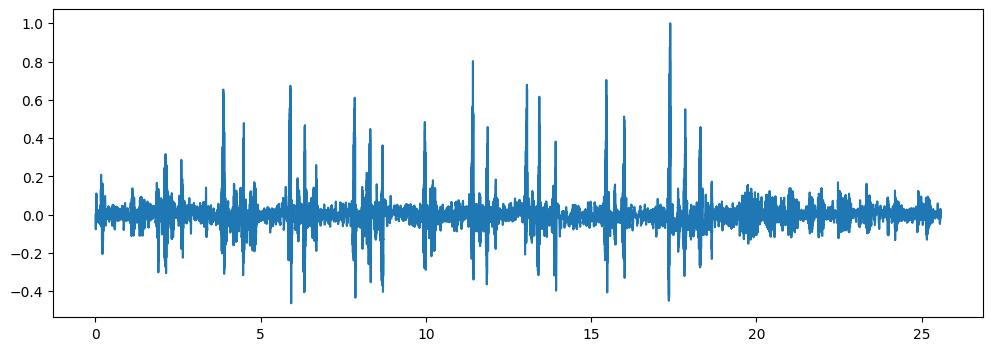

In [43]:
name1 = '104_1b1_Ar_sc_Litt3200.wav'

audio, sr = read_audio_content(join(AUDIO_TXT_DIR, name1))  #type: ignore

duration = len(audio) / sr
time = np.arange(0, duration, 1 / sr)

plt.figure(figsize=FIGSIZE)
plt.plot(time, audio)
print(len(np.arange(0, len(audio), 1)), len(audio))

segment_audio_content(audio, sr, 5)

# Audio(audio[sr * 0 : sr * 5], rate=sr)
# Audio(audio[sr * 5 : sr * 10], rate=sr)
# Audio(audio[sr * 10 : sr * 15], rate=sr)
# Audio(audio[sr * 15 : sr * 20], rate=sr)
# Audio(audio[sr * 20 : sr * 25], rate=sr)
# Audio(audio[sr * 25 : sr * 30], rate=sr)

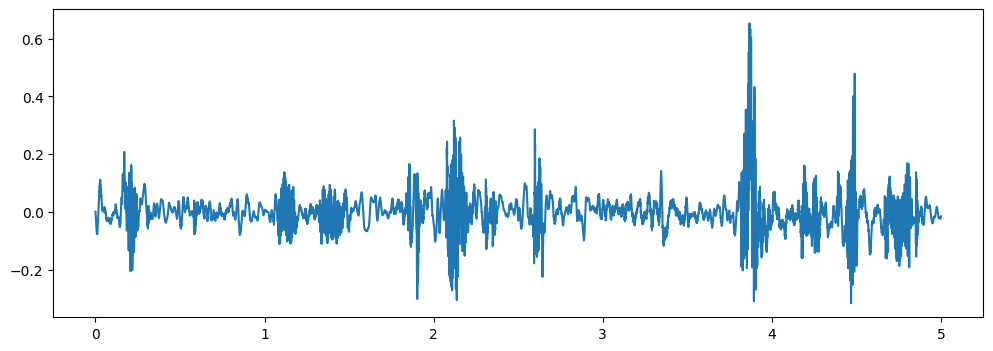

In [5]:
# audio = denoise_wavelet(audio, wavelet='db5', mode='soft', wavelet_levels=4)
audio_w = denoise_wavelet(audio, wavelet='db5', method='BayesShrink', mode='soft', wavelet_levels=4)
plt.figure(figsize=FIGSIZE)
plt.plot(time, audio_w)

In [6]:
print(len(time))

20000


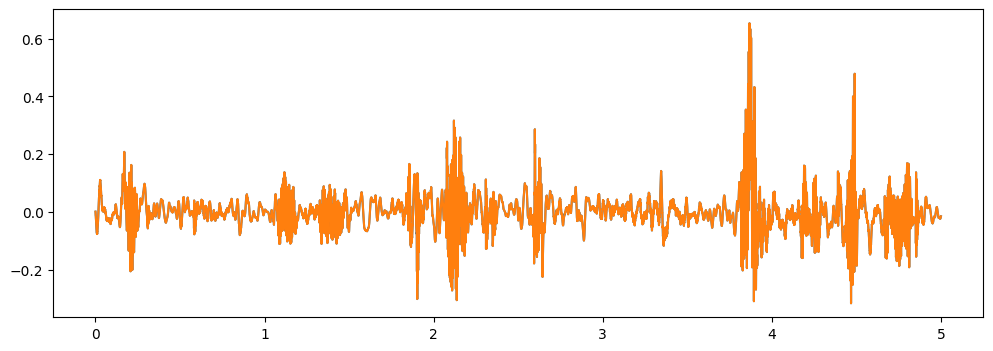

In [7]:
result = apply_loess(audio_w, frac=0)

x = [ r[0] for r in result ]
y = [ r[1] for r in result ]

plt.figure(figsize=FIGSIZE)
plt.plot(time, audio)
plt.plot(time, y)


In [8]:
Audio(y, rate=sr)

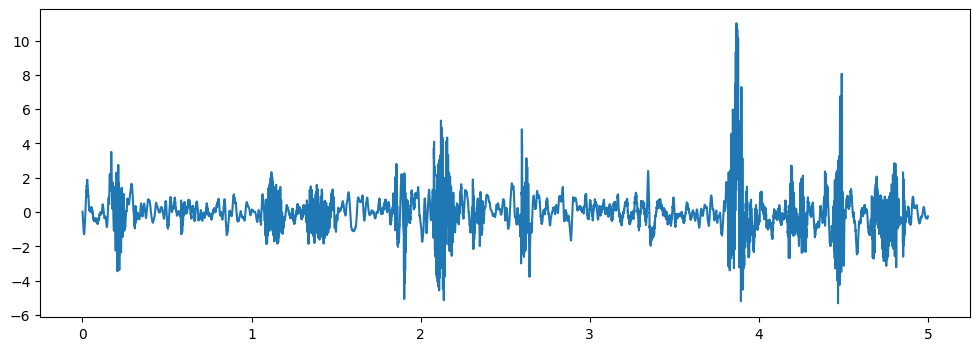

In [9]:
audio_z = zscore_normalize(y)
plt.figure(figsize=FIGSIZE)
plt.plot(time, audio_z)
Audio(data=audio_z, rate=sr)

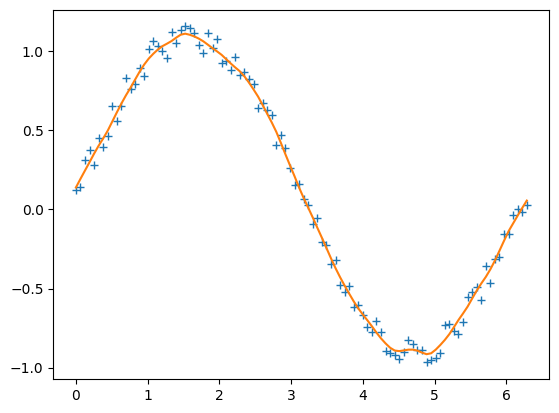

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
lowess = sm.nonparametric.lowess(y, x, frac=0.1)

plt.plot(x, y, '+')
plt.plot(lowess[:, 0], lowess[:, 1])
plt.show()

## Training

In [11]:
def create_model(num_classes: int) -> tf.keras.models.Sequential:
    '''
    '''
    
    model = Sequential(layers=[

        Conv1D(filters=16, kernel_size=(32,), strides=(1,), kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001)),
        BatchNormalization(),
        ReLU(),
        Dropout(rate=0.3),

        Conv1D(filters=16, kernel_size=(32,), strides=(1,), kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001)),
        BatchNormalization(),
        ReLU(),
        Dropout(rate=0.3),

        Conv1D(filters=16, kernel_size=(32,), strides=(1,), kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001)),
        MaxPooling1D(pool_size=(2,), strides=(2,)),
        BatchNormalization(),
        ReLU(),

        Bidirectional(
            layer=LSTM(units=100, kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001))
        ),

        Dropout(rate=0.2),

        Softmax()
    ])

    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss='category_crossentropy',
        metrics=[tfa.metrics.CohenKappa(num_classes=num_classes)],
    )

    return model 


### Label count

In [20]:
df_diagnosis_count = df_audio_diagnosis.groupby('Diagnosis')['Diagnosis'].count()
num_classes = len(df_diagnosis_count)
print(num_classes, 'classes')
print(df_diagnosis_count)

6 classes
Diagnosis
Bronchiectasis     5
Bronchiolitis      2
COPD              41
Healthy           46
Pneumonia          7
URTI               6
Name: Diagnosis, dtype: int64


### 10-Fold Cross Validation

In [18]:
from sklearn.model_selection import StratifiedKFold

X = df_audio_diagnosis.loc[:, 'audio_data']
y = df_audio_diagnosis.loc[:, 'Diagnosis']

for train_idx, test_idx in StratifiedKFold(n_splits=10).split(X, y):
    print()

KeyError: 'audio_data'